* [Functions](Functions)
* [Angle changes](#Angle-changes)
* [results](#results)


### Imports and configs

In [ ]:

import os, warnings
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
from IPython.display import display, Image as DImg

warnings.filterwarnings("ignore")
plt.rcParams.update({
    "savefig.dpi":      600,
    "font.size":        10,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
})

N_TS, CYCLE_LEN = 21, 1.0
SMOOTH          = (9, 3)
PAD             = 1.05
LINE_STYLES     = ['-', '--', '-.', ':', (0, (3,1,1,1))]
END_SYSTOLIC_TIMEPOINT = 0.4


DATA_FILES = {
     '$S4, 90^{\circ}$': './data/week4_patch4_90.csv',   
    '$S5,90^{\circ}$':   './data/week4_patch5_90.csv',
    #  '$S4, 45^{\circ}$': './data/week4_patch5_45.csv',  
}

OUT = Path("./twist_outputs"); OUT.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings

warnings.filterwarnings('ignore')

ALL_PATHS = [Path(v) for v in DATA_FILES.values()]

# Functions 

In [ ]:
def col_names(n):
    base = ['node_number','x','y','z','r','theta']
    time = [f"{c}{i}" for i in range(n) for c in ('x','y','z','r','theta')]
    return base + time

def load_csv(path,n):
    df = pd.read_csv(path,header=None)
    actual_cols = len(df.columns)
    expected_cols = 6 + 5*n  # base + time columns
    
    if actual_cols < expected_cols: 
        # Fewer time points than expected for different simulations 
        actual_n = (actual_cols - 6) // 5
        df.columns = col_names(actual_n)
        return df, actual_n
    else:
        df.columns = col_names(n)
        return df, n

def unwrap_baseline(arr):
    """Process angles starting from zero baseline"""
    deg = np.rad2deg(np.unwrap(arr))
    # Force zero baseline - subtract initial value
    return deg - deg[0]

def segment(df,n):
    edges=np.linspace(df['y'].min(),df['y'].max(),6)
    masks=[
        (df['y']>=edges[0])&(df['y']<edges[1]),   # base
        (df['y']>=edges[2])&(df['y']<edges[3]),   # mid
        (df['y']>=edges[-2])                      # apex
    ]
    out=[]
    for m in masks:
        out.append(None if df[m].empty else
                   np.vstack([df[m][f'theta{i}'] for i in range(n)]).T)
    return out   # base, mid, apex

def calculate_comprehensive_stats(data_array):
    """Calculate comprehensive statistics for twist data"""
    if data_array is None or len(data_array) == 0:
        return {}
    
    data_flat = data_array.flatten() if data_array.ndim > 1 else data_array
    
    return {
        'mean': np.mean(data_flat),
        'std': np.std(data_flat, ddof=1),
        'median': np.median(data_flat),
        'min': np.min(data_flat),
        'max': np.max(data_flat),
        'range': np.ptp(data_flat),
        'q25': np.percentile(data_flat, 25),
        'q75': np.percentile(data_flat, 75),
        'iqr': np.percentile(data_flat, 75) - np.percentile(data_flat, 25),
        'cv': np.std(data_flat, ddof=1) / np.abs(np.mean(data_flat)) * 100 if np.mean(data_flat) != 0 else 0,
        'rms': np.sqrt(np.mean(data_flat**2)),
        'skewness': stats.skew(data_flat),
        'kurtosis': stats.kurtosis(data_flat),
        'var': np.var(data_flat, ddof=1)
    }

def calc_metrics(th_b,th_m,th_a,n_actual):
    a_rel = unwrap_baseline(th_a.mean(0))
    b_rel = unwrap_baseline(th_b.mean(0))
    m_rel = unwrap_baseline(th_m.mean(0)) if th_m is not None else None
    twist = a_rel - b_rel
    if len(twist) >= min(SMOOTH[0], n_actual):
        smooth_window = min(SMOOTH[0], n_actual if n_actual % 2 == 1 else n_actual-1)
        if smooth_window >= 3:
            twist=savgol_filter(twist, smooth_window, min(SMOOTH[1], smooth_window-1))
    
    apex_stats = calculate_comprehensive_stats(a_rel)
    base_stats = calculate_comprehensive_stats(b_rel)
    mid_stats = calculate_comprehensive_stats(m_rel) if m_rel is not None else {}
    twist_stats = calculate_comprehensive_stats(twist)
    
    apex_nodal_stats = calculate_comprehensive_stats(th_a) if th_a is not None else {}
    base_nodal_stats = calculate_comprehensive_stats(th_b) if th_b is not None else {}
    mid_nodal_stats = calculate_comprehensive_stats(th_m) if th_m is not None else {}
    
    return dict(
        apex=a_rel, mid=m_rel, base=b_rel, twist=twist,
        n_timepoints=n_actual,
        peak=np.abs(twist).max(),
        es=twist[int(END_SYSTOLIC_TIMEPOINT*(n_actual-1))] if n_actual > 1 else twist[0],
        
        apex_temporal_stats=apex_stats,
        base_temporal_stats=base_stats,
        mid_temporal_stats=mid_stats,
        twist_temporal_stats=twist_stats,
        
        apex_spatial_stats=apex_nodal_stats,
        base_spatial_stats=base_nodal_stats,
        mid_spatial_stats=mid_nodal_stats,
        
        twist_rate_max=np.max(np.diff(twist)) if len(twist) > 1 else 0,
        twist_rate_min=np.min(np.diff(twist)) if len(twist) > 1 else 0,
        systolic_twist=np.max(twist[:int(END_SYSTOLIC_TIMEPOINT*(n_actual-1))]) if n_actual > int(END_SYSTOLIC_TIMEPOINT*(n_actual-1)) else 0,
        diastolic_untwist=twist[int(END_SYSTOLIC_TIMEPOINT*(n_actual-1))] - twist[-1] if n_actual > int(END_SYSTOLIC_TIMEPOINT*(n_actual-1)) else 0
    )


# Angle changes
### $\Delta\theta$

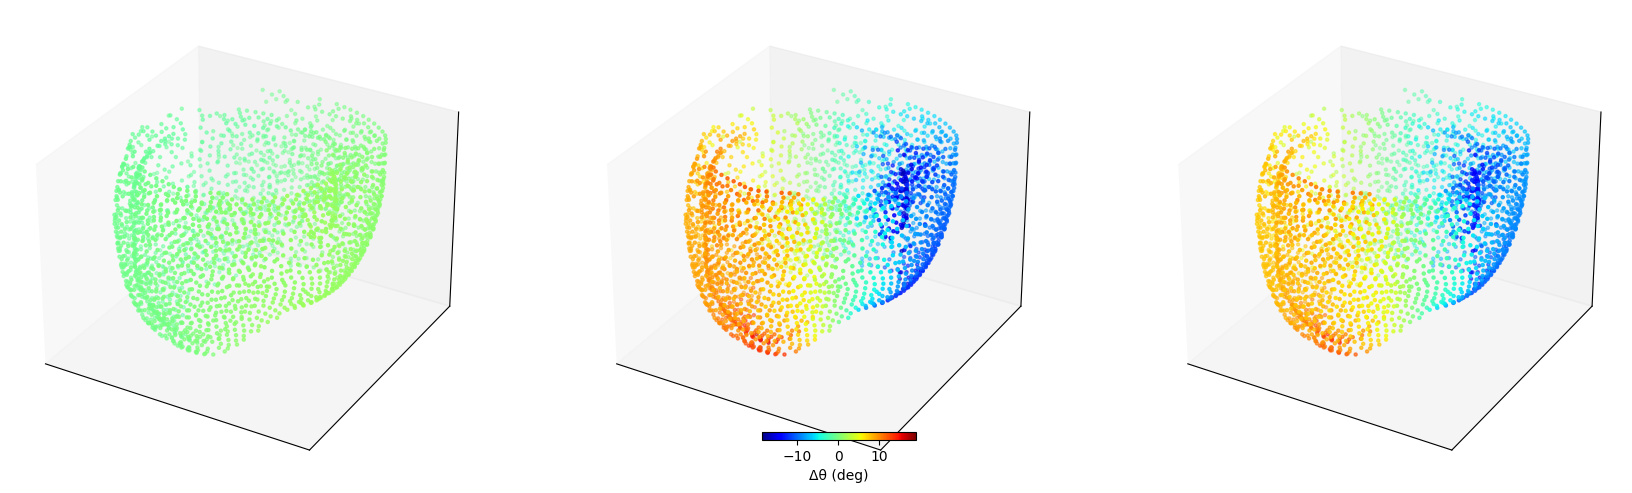

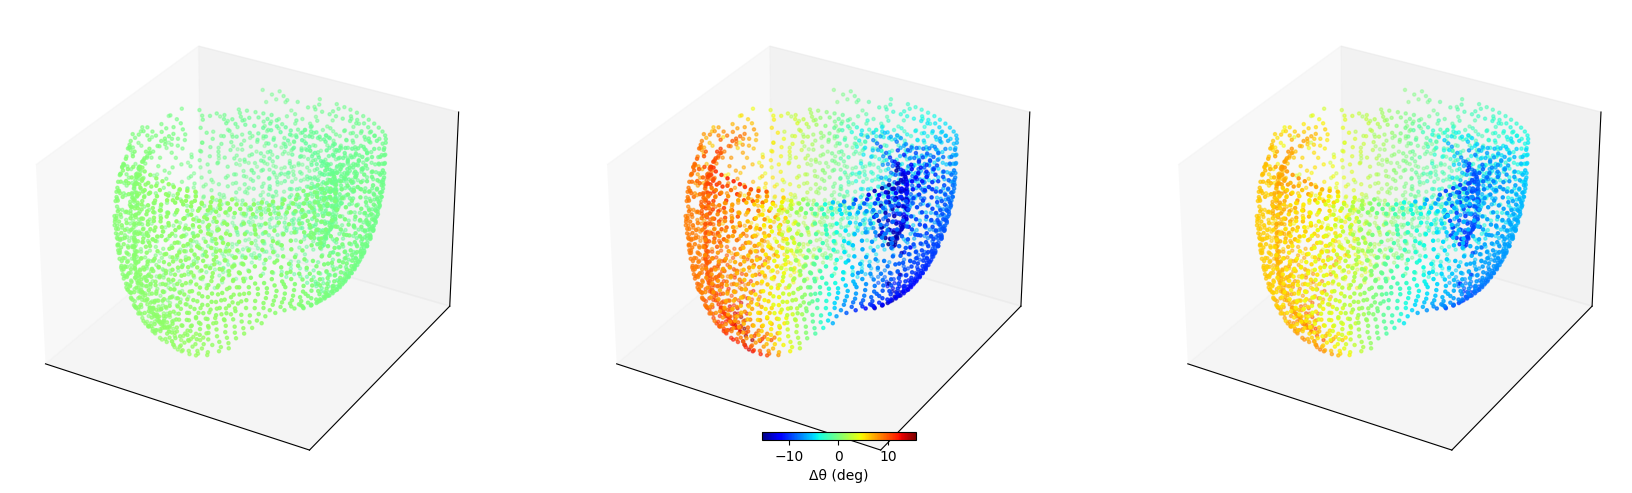

In [32]:

for CSV_PATH in ALL_PATHS:
    df = pd.read_csv(CSV_PATH, header=None)

    base_cols = ['node_number', 'x', 'y', 'z', 'r', 'theta']
    num_cols = df.shape[1]
    ts = (num_cols - len(base_cols)) // 5
    time_cols = [f"{coord}{i}" for i in range(ts) for coord in ('x','y','z','r','theta')]
    df.columns = base_cols + time_cols

    theta0 = df['theta0'].values
    delta_all = np.array([ np.degrees(((df[f'theta{t}'] - theta0 + np.pi) % (2*np.pi)) - np.pi)  for t in range(ts)])

    r0 = df['r0']
    r_thresh = np.percentile(r0, 20)
    mask = r0 > r_thresh

    vmin, vmax = delta_all[:, mask].min(), delta_all[:, mask].max()

    TIMESTEPS = [2, 8, 12]
    FIGSIZE = (18, 5)
    MARKER_SIZE = 5
    CMAP = 'jet'

    fig = plt.figure(figsize=FIGSIZE)
    axes = []

    for idx, t in enumerate(TIMESTEPS):
        ax = fig.add_subplot(1, len(TIMESTEPS), idx+1, projection='3d')
        x = df.loc[mask, 'z']
        y = df.loc[mask, 'x']
        z = df.loc[mask, 'y']
        sc = ax.scatter(x, y, z, c=delta_all[t, mask], cmap=CMAP, vmin=vmin, vmax=vmax, s=MARKER_SIZE)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.grid(False)
        axes.append(ax)

    cbar = fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label('Δθ (deg)')

    plt.tight_layout()
    plt.show()


# results

✔ saved → twist_outputs\comparison_twist_enhanced.png

TWIST ANALYSIS SUMMARY

$S4, 90^{\circ}$:
  Peak Twist:      5.22° ± 2.44°
  ES Twist:        3.77° ± 2.44°
  Systolic Twist:  5.22° ± 2.44°
  Diastolic Untwist: 6.74° ± 2.44°
  Twist Range:     8.20°
  Twist CV:        163.8%
  Apex Rotation:   -6.97° ± 3.82°
  Base Rotation:   -8.45° ± 5.85°
  Mid Rotation:    -7.73° ± 3.94°

$S5,90^{\circ}$:
  Peak Twist:      4.27° ± 2.54°
  ES Twist:        -1.46° ± 2.54°
  Systolic Twist:  4.27° ± 2.54°
  Diastolic Untwist: -0.03° ± 2.54°
  Twist Range:     7.74°
  Twist CV:        368.7%
  Apex Rotation:   -3.45° ± 2.81°
  Base Rotation:   -2.79° ± 4.80°
  Mid Rotation:    -3.16° ± 2.68°


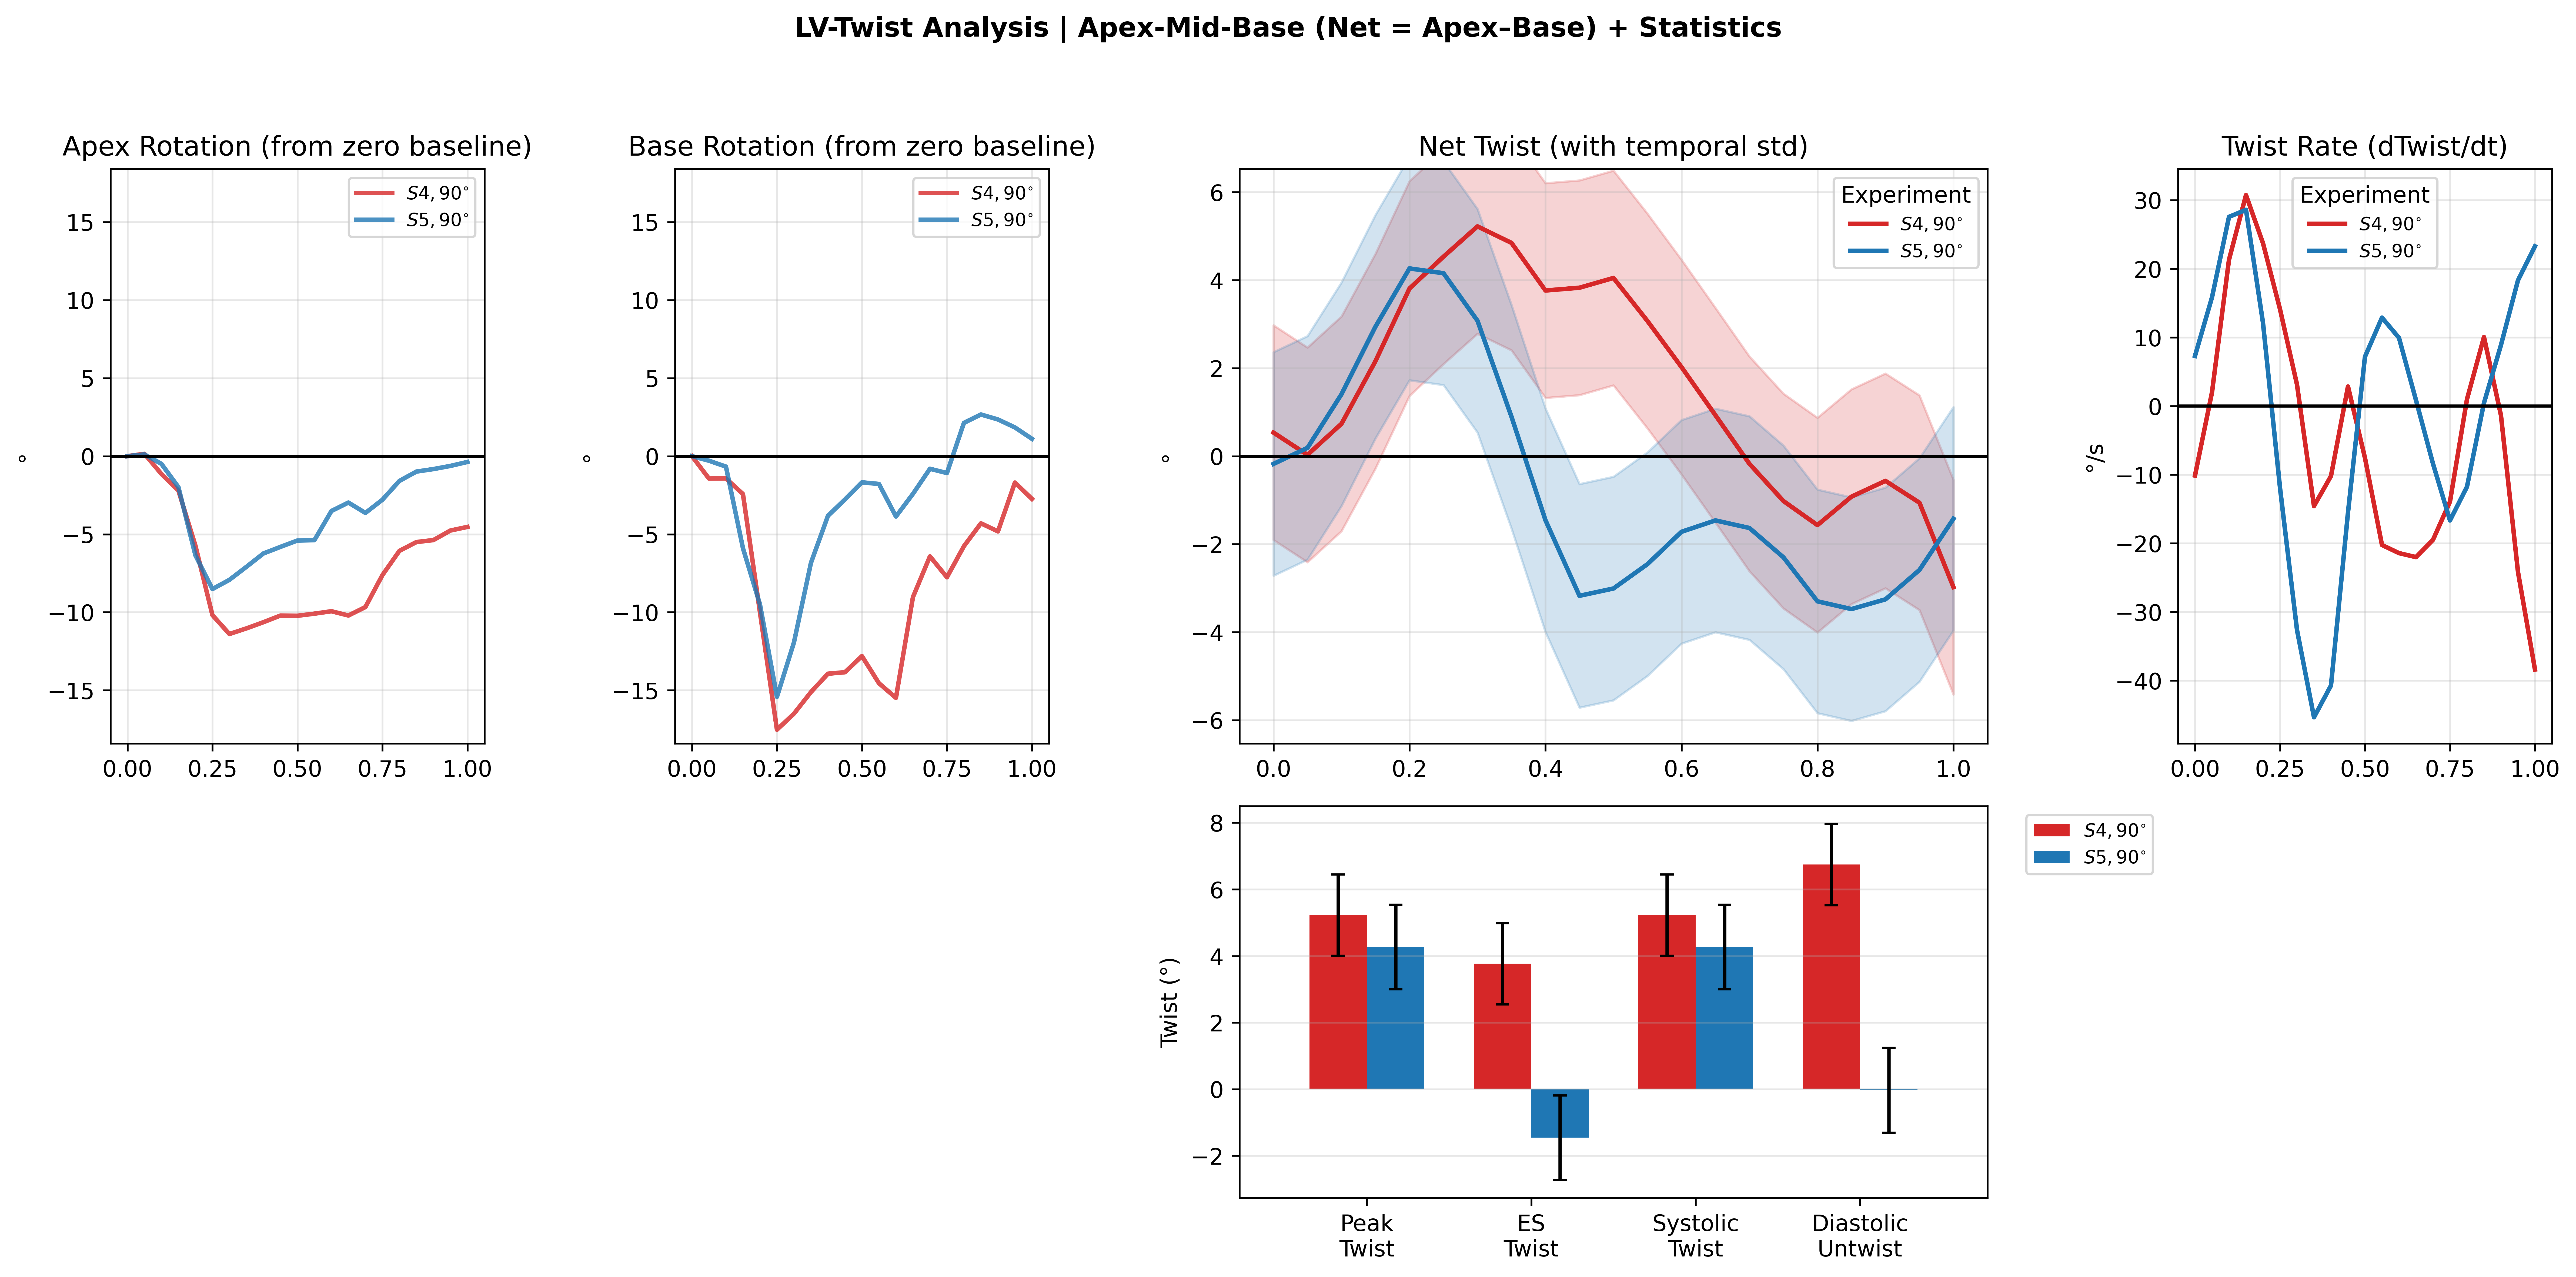

In [33]:

results={}
for lbl,fp in DATA_FILES.items():
    if not os.path.isfile(fp): print("✖",fp); continue
    df, n_actual = load_csv(fp,N_TS)
    th_b,th_m,th_a=segment(df,n_actual)
    if th_b is None or th_a is None:
        print(f"⚠ {lbl}: missing apex/base – skipped"); continue
    results[lbl]=calc_metrics(th_b,th_m,th_a,n_actual)

rot_vals=np.concatenate([np.concatenate([m['apex'],m['base']])
                            for m in results.values()])
rot_max=PAD*np.abs(rot_vals).max()
tw_vals=np.concatenate([m['twist'] for m in results.values()])
tw_max=1.25*np.abs(tw_vals).max()

fig,ax=plt.subplots(2,4,figsize=(16,8),
                    gridspec_kw={"height_ratios":[2.2,1.5], "width_ratios":[1,1,2,1]},
                    facecolor='white')
style_cycle = LINE_STYLES*10

colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:orange', 'tab:green']

for i, ((lbl,m),ls) in enumerate(zip(results.items(),style_cycle)):
    color = colors[i % len(colors)]
    n_actual = m['n_timepoints']
    t_actual = np.linspace(0,CYCLE_LEN,n_actual)
    
    ax[0,0].plot(t_actual,m['apex'],ls='-',lw=2,color=color, alpha=0.8, label=lbl)
    ax[0,1].plot(t_actual,m['base'],ls='-',lw=2,color=color, alpha=0.8, label=lbl)
    
    twist_std = m['twist_temporal_stats']['std']
    ax[0,2].plot(t_actual,m['twist'],ls='-',lw=2,color=color,label=lbl)
    ax[0,2].fill_between(t_actual, m['twist']-twist_std, m['twist']+twist_std,  alpha=0.2, color=color)
    
    twist_rate = np.gradient(m['twist'], t_actual)
    ax[0,3].plot(t_actual,twist_rate,ls='-',lw=2,color=color,label=lbl)

for a in (ax[0,0],ax[0,1],ax[0,2],ax[0,3]): a.axhline(0,color='black',lw=1.4)

ax[0,0].set(title='Apex Rotation (from zero baseline)',ylabel='°', ylim=[-rot_max,rot_max]); ax[0,0].grid(alpha=.3)
ax[0,0].legend(fontsize=8)

ax[0,1].set(title='Base Rotation (from zero baseline)',ylabel='°', ylim=[-rot_max,rot_max]); ax[0,1].grid(alpha=.3)
ax[0,1].legend(fontsize=8)

ax[0,2].set(title='Net Twist (with temporal std)',ylabel='°', ylim=[-tw_max,tw_max]); ax[0,2].grid(alpha=.3)
ax[0,2].legend(title='Experiment',fontsize=8)

ax[0,3].set(title='Twist Rate (dTwist/dt)',ylabel='°/s'); ax[0,3].grid(alpha=.3)
ax[0,3].legend(title='Experiment',fontsize=8)

bars=ax[1,2]
x=np.arange(4)          
width=0.7/len(results)
for i,(lbl,m) in enumerate(results.items()):
    color = colors[i % len(colors)]
    values = [m['peak'], m['es'], m['systolic_twist'], m['diastolic_untwist']]
    errors = [m['twist_temporal_stats']['std']/2] * 4  # Use std as error estimate
    bars.bar(x+i*width, values, width, label=lbl, yerr=errors, capsize=3, color=color)

bars.set_xticks(x+width*(len(results)-1)/2)
bars.set_xticklabels(['Peak\nTwist','ES\nTwist', 'Systolic\nTwist', 'Diastolic\nUntwist'])
bars.set_ylabel('Twist (°)')
bars.grid(alpha=.3,axis='y')
bars.legend(fontsize=8, bbox_to_anchor=(1.04,1), loc='upper left')

right_edge = x[-1] + width*(len(results)-1) + 0.6
bars.set_xlim(-0.6, right_edge)

ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,3].axis('off')

fig.suptitle('LV-Twist Analysis | Apex-Mid-Base (Net = Apex–Base) + Statistics',fontweight='bold')
fig.tight_layout(rect=[0,0,1,.95])

out=OUT/"comparison_twist_enhanced.png"
fig.savefig(out,facecolor='white',bbox_inches='tight')
plt.close(fig)
print("✔ saved →",out)

summary_data = []
detailed_data = []

for label, metrics in results.items():
    summary_row = {
        'Dataset': label,
        'PeakTwist': metrics['peak'],
        'ESTwist': metrics['es'],
        'SystolicTwist': metrics['systolic_twist'],
        'DiastolicUntwist': metrics['diastolic_untwist'],
        'TwistRate_Max': metrics['twist_rate_max'],
        'TwistRate_Min': metrics['twist_rate_min'],
        'Twist_Mean': metrics['twist_temporal_stats']['mean'],
        'Twist_Std': metrics['twist_temporal_stats']['std'],
        'Twist_CV': metrics['twist_temporal_stats']['cv'],
        'Twist_Range': metrics['twist_temporal_stats']['range']
    }
    summary_data.append(summary_row)
    
    for region in ['apex', 'base', 'mid']:
        if f'{region}_temporal_stats' in metrics and metrics[f'{region}_temporal_stats']:
            temp_stats = metrics[f'{region}_temporal_stats']
            spatial_stats = metrics[f'{region}_spatial_stats']
            detailed_row = {
                'Dataset': label,
                'Region': region.capitalize(),
                'Temporal_Mean': temp_stats['mean'],
                'Temporal_Std': temp_stats['std'],
                'Temporal_Median': temp_stats['median'],
                'Temporal_Min': temp_stats['min'],
                'Temporal_Max': temp_stats['max'],
                'Temporal_Range': temp_stats['range'],
                'Temporal_Q25': temp_stats['q25'],
                'Temporal_Q75': temp_stats['q75'],
                'Temporal_IQR': temp_stats['iqr'],
                'Temporal_CV': temp_stats['cv'],
                'Temporal_RMS': temp_stats['rms'],
                'Temporal_Skewness': temp_stats['skewness'],
                'Temporal_Kurtosis': temp_stats['kurtosis'],
                'Spatial_Mean': spatial_stats.get('mean', np.nan),
                'Spatial_Std': spatial_stats.get('std', np.nan),
                'Spatial_CV': spatial_stats.get('cv', np.nan),
                'Spatial_Range': spatial_stats.get('range', np.nan)
            }
            detailed_data.append(detailed_row)

pd.DataFrame(summary_data).to_csv(OUT/"twist_summary_enhanced.csv", index=False)
pd.DataFrame(detailed_data).to_csv(OUT/"twist_detailed_stats.csv", index=False)

stats_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("TWIST ANALYSIS SUMMARY")
print("="*80)

for label, metrics in results.items():
    print(f"\n{label}:")
    print(f"  Peak Twist:      {metrics['peak']:.2f}° ± {metrics['twist_temporal_stats']['std']:.2f}°")
    print(f"  ES Twist:        {metrics['es']:.2f}° ± {metrics['twist_temporal_stats']['std']:.2f}°")
    print(f"  Systolic Twist:  {metrics['systolic_twist']:.2f}° ± {metrics['twist_temporal_stats']['std']:.2f}°")
    print(f"  Diastolic Untwist: {metrics['diastolic_untwist']:.2f}° ± {metrics['twist_temporal_stats']['std']:.2f}°")
    print(f"  Twist Range:     {metrics['twist_temporal_stats']['range']:.2f}°")
    print(f"  Twist CV:        {metrics['twist_temporal_stats']['cv']:.1f}%")
    
    print(f"  Apex Rotation:   {metrics['apex_temporal_stats']['mean']:.2f}° ± {metrics['apex_temporal_stats']['std']:.2f}°")
    print(f"  Base Rotation:   {metrics['base_temporal_stats']['mean']:.2f}° ± {metrics['base_temporal_stats']['std']:.2f}°")
    if metrics['mid_temporal_stats']:
        print(f"  Mid Rotation:    {metrics['mid_temporal_stats']['mean']:.2f}° ± {metrics['mid_temporal_stats']['std']:.2f}°")


if 'get_ipython' in globals(): display(DImg(out))


In [15]:
stats_summary

,Dataset,PeakTwist,ESTwist,SystolicTwist,DiastolicUntwist,TwistRate_Max,TwistRate_Min,Twist_Mean,Twist_Std,Twist_CV,Twist_Range
0,"$S4, 90^{\circ}$",5.222585,3.765448,5.222585,6.741590,1.649018,-1.919216,1.489381,2.440261,163.843944,8.198727
1,"$S4, 45^{\circ}$",6.735373,4.885160,6.735373,4.174224,1.927242,-2.161093,2.798151,3.219056,115.042263,9.266571
